In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import impute
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
import lightgbm as lgbm
import seaborn as sns

In [51]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Data Cleaning

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [53]:
obj_cols = train.select_dtypes(include='object').columns.tolist()
num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()

In [54]:
## fill nan value to median

In [55]:
imp_median = impute.SimpleImputer(missing_values=np.nan, strategy='median')

In [56]:
for num_col in num_cols:
    if train[num_col].isnull().values.any():
        print('imputing for {}'.format(num_col))
        train[num_col] = imp_median.fit_transform(train[num_col].values.reshape(-1,1)) 

start imputing for Age


In [58]:
train['Cabin'].fillna('None', inplace = True)

In [77]:
train['ticket_len'] = train['Ticket'].str.count(r'[a-zA-Z0-9 ]')

## Feature Scale

In [79]:
skew_cols = train[num_cols].skew().sort_values(ascending = False)
skew_cols = skew_cols[abs(skew_cols) > 2].index.values.tolist()

### Log Transform

In [81]:
def log_transform(df, column):
    return np.log(df[column] + 1)

In [82]:
train_processed = train.copy()
for skew_col in skew_cols:
    train_processed[skew_col] = log_transform(train_processed, skew_col)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26c02b38>,
      dtype=object)

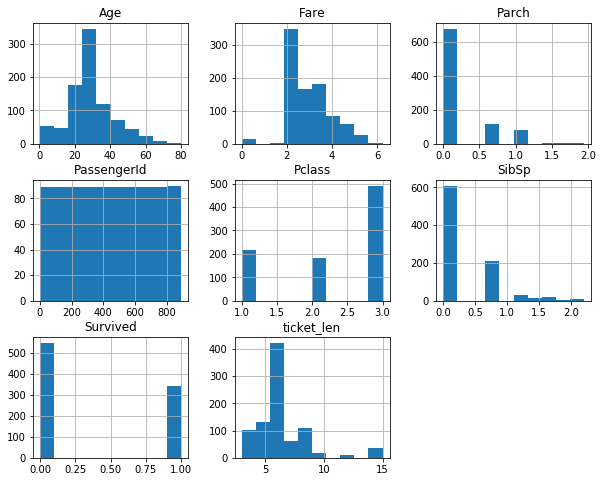

In [83]:
train_processed.hist(figsize=(10,8))

## Train-Test Split and Feature Separation

In [94]:
cols_to_exclude = ['PassengerId','Survived','Ticket','Name']

In [95]:
feat_cols = [x for x in train.columns.values.tolist() if x not in cols_to_exclude]

In [97]:
features = pd.get_dummies(train_processed[feat_cols])

In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(features, train['Survived'], test_size=0.2, random_state=42)

### Feature Importances

In [115]:
scale_pos_weight_val = train_processed['Survived'].value_counts()[0]//train_processed['Survived'].value_counts()[1]

In [117]:
model = lgbm.LGBMClassifier(objective ='binary',
    learning_rate = 0.01,
    num_leaves = 76,
    n_estimators = 1000,
    feature_fraction= 0.64, 
    bagging_fraction= 0.8, 
    bagging_freq=1,
    boosting_type = 'gbdt',
    metric= 'binary_logloss',
    scale_pos_weight = scale_pos_weight_val,
    silent = True,
    n_jobs = -1)

In [118]:
model.fit(X_train, y_train, 
          eval_metric = ['auc', 'binary_logloss'],
          eval_set = [(X_valid, y_valid)],
          early_stopping_rounds = 500, 
          verbose = True)

[1]	valid_0's auc: 0.854698	valid_0's binary_logloss: 0.676279
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.861454	valid_0's binary_logloss: 0.671489
[3]	valid_0's auc: 0.868726	valid_0's binary_logloss: 0.667235
[4]	valid_0's auc: 0.862355	valid_0's binary_logloss: 0.663498
[5]	valid_0's auc: 0.856242	valid_0's binary_logloss: 0.659439
[6]	valid_0's auc: 0.865894	valid_0's binary_logloss: 0.655254
[7]	valid_0's auc: 0.863964	valid_0's binary_logloss: 0.651662
[8]	valid_0's auc: 0.867439	valid_0's binary_logloss: 0.647666
[9]	valid_0's auc: 0.869305	valid_0's binary_logloss: 0.644279
[10]	valid_0's auc: 0.872329	valid_0's binary_logloss: 0.640472
[11]	valid_0's auc: 0.870785	valid_0's binary_logloss: 0.637221
[12]	valid_0's auc: 0.871622	valid_0's binary_logloss: 0.633609
[13]	valid_0's auc: 0.87471	valid_0's binary_logloss: 0.629731
[14]	valid_0's auc: 0.87471	valid_0's binary_logloss: 0.626356
[15]	valid_0's auc: 0.874903	valid_0's binary_logloss

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.64,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
        n_jobs=-1, num_leaves=76, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [119]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

feature_imp['cum_pct'] = feature_imp['Value'].cumsum()/feature_imp['Value'].sum()

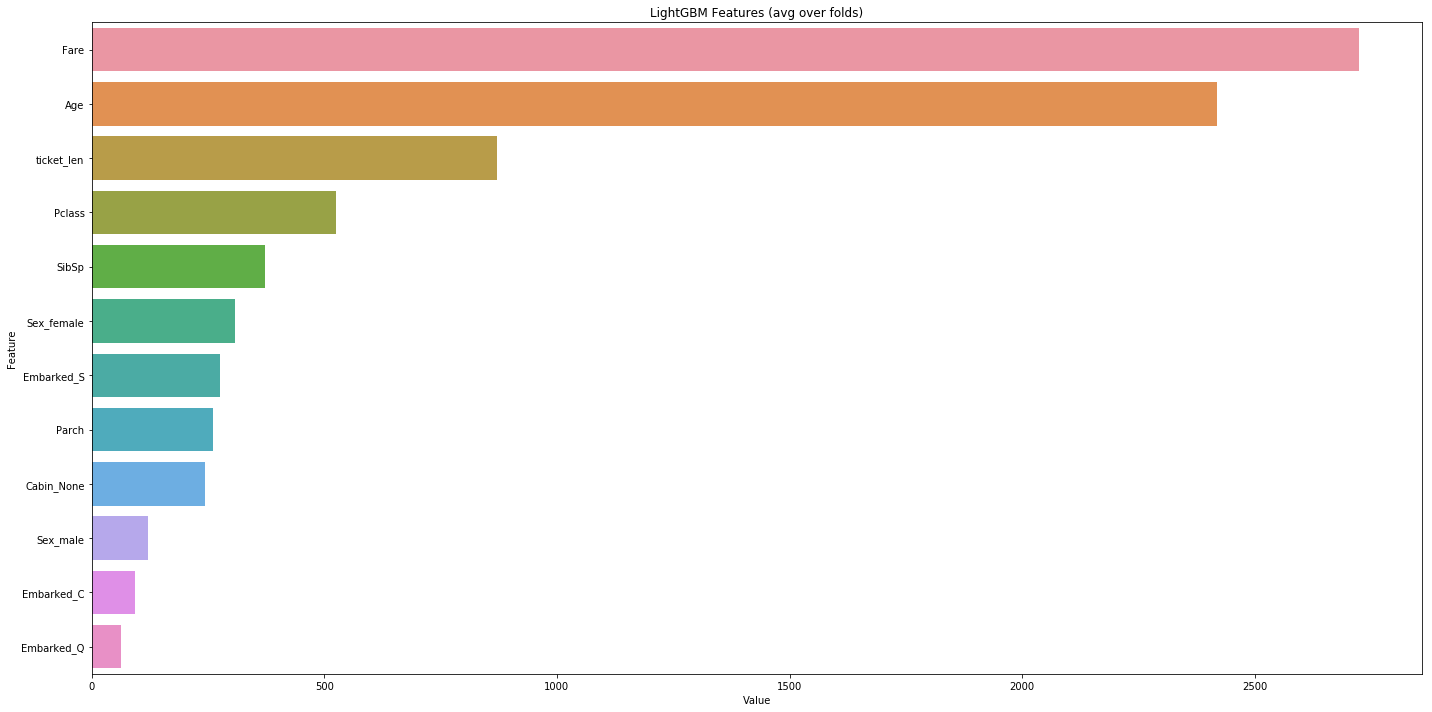

In [123]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.loc[feature_imp['Value'] > 0].sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [129]:
top_feats = feature_imp.loc[feature_imp['Value'] > 0].Feature.values.tolist()

## Model Benchmarking

#### Linear, Logistic, Random Forest, XGBoost, CatBoost